# Assignment 2  - Classification
### Due Date: 3 April 11.59pm (or 6 April 11.59pm if late period is used)
### Chan Wei Xin (E0267382)
Sentences in <span style="color:blue">blue</span> indicate questions to be answered. 

If you wish to type math equations in markdown, follow this link: https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Working%20With%20Markdown%20Cells.html#LaTeX-equations

Please save this Jupyter notebook as __YourNameInLumiNUS_YourNUSNETID.ipynb__.

If you have further questions, you can post on the LumiNUS forums, or email Wenjie Wang (e0409768@u.nus.edu) or the lecturer, Bryan Hooi (bhooi@comp.nus.edu.sg).

### Introduction
In this assignment, you are a data scientist at the Pima Womans Hospital of Arizona. You have been asked by the hospital to develop a computer program that can accurately diagnose whether a patient has diabetes. You are provided with a dataset containing historical records of measurements and outcomes. You will be using some common data mining libraries to achieve your objective. Detailed instructions and questions are given in the following sections.

### Dataset
The Pima Indians of Arizona have the highest rate of obesity and diabetes ever recorded. This dataset was collected by the National Institute of Diabetes and Digestive and Kidney Diseases, with the objective to predict whether or not a patient has diabetes based on certain diagnostic measurements. All the patients recorded in this dataset are females of the Pima Indian heritage. The dataset consists of 8 medical predictor variables and one target variable, Outcome. Table 1 shows the description of each variable. Your task is to build classiﬁcation models for predicting Outcome based on the other variables.


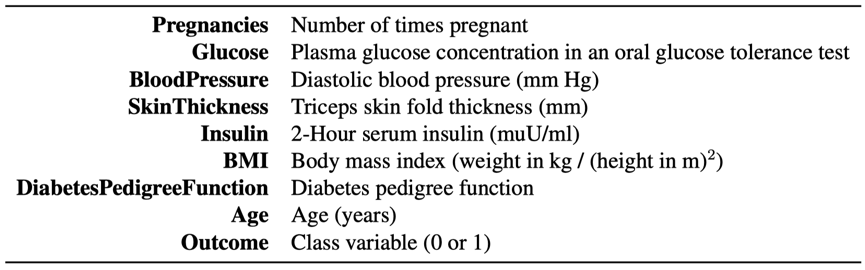

**----- Import all libraries here -----**

In [2]:
# data manipulation
import pandas as pd
import numpy as np

# visualiation
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline

# feature engineering
from sklearn.preprocessing import StandardScaler

# model training
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# model evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

# classifiers
from sklearn.neighbors import KNeighborsClassifier # KNN
from sklearn.linear_model import LogisticRegression # logistic regression
from sklearn.tree import DecisionTreeClassifier # decision tree
from sklearn.ensemble import RandomForestClassifier # random forest
from sklearn.ensemble import GradientBoostingClassifier # gradient boosting

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

## 1. Data Cleaning and Analysis (10 points)

<span style="color:blue">Load the CSV file into a *DataFrame* object named **pima** using Pandas to examine the dataset and perform data cleaning:</span>
    
<span style="color:blue">1) Print the dtype of each column to review the data types of the attributes in the dataset. *(2 points)*</span>

In [3]:
# --- Your code here ---
pima = pd.read_csv("diabetes.csv")
print(pima.dtypes)

Pregnancies                   int64
Glucose                       int64
BloodPressure               float64
SkinThickness               float64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object


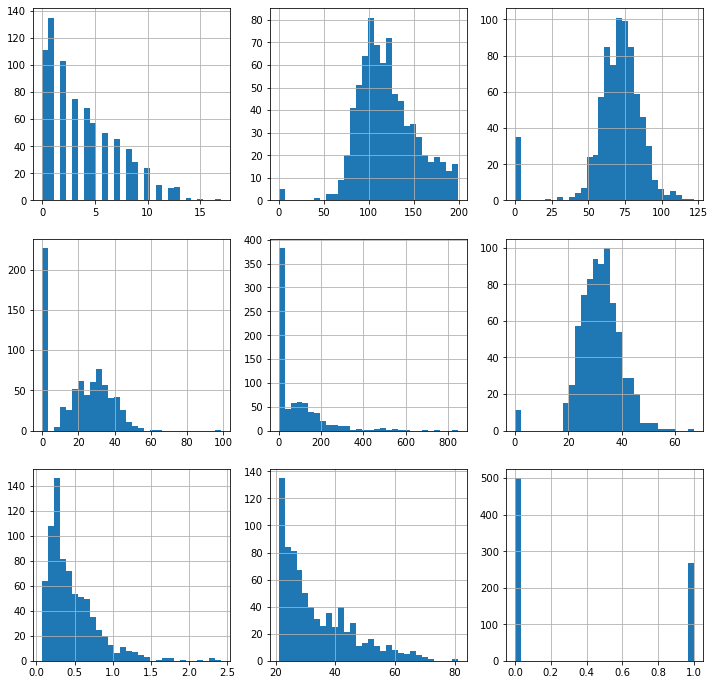

<span style="color:blue">2) Are there any missing values in the dataset? For each attribute in the dataset, print out the total number of missing values in the dataset for that attribute. How would you handle the missing values without deleting any record?*(3 points)*
<br/>
_(Hint: you can use the **fillna** function to replace them with the means of the corresponding columns if there are only a few missing values.)_
</span>

There are missing values in the dataset. The missing values can be imputed with the mean of the respective features.

In [57]:
# --- Your code here ---
print('Before replacing missing values: ')
print(pima.isnull().sum(axis=0))

pima_fill = pima.fillna(pima.mean())

print('\nAfter replacing missing values: ')
print(pima_fill.isnull().sum(axis=0))

Before replacing missing values: 
Pregnancies                 0
Glucose                     0
BloodPressure               1
SkinThickness               1
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    1
Age                         0
Outcome                     0
dtype: int64

After replacing missing values: 
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


<span style="color:blue">3) Show the count of “0”s and “1”s in *Outcome* using a bar graph. Write down what you observe in the bar plot. How does this observation affect what metrics you would use to evaluate a classifier for predicting *Outcome*?*(5 points)*
<br/>_(Hint: you can draw the bar plot with the help of **sb.countplot**.)_
</span>

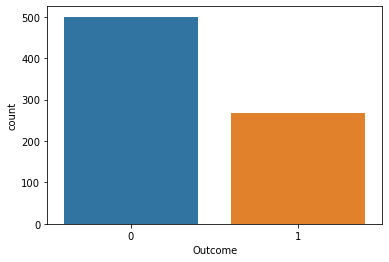

In [8]:
# --- Your code here ---
fig, ax = plt.subplots(1,1)
sb.countplot(x=pima_fill.Outcome)
plt.show()

# print(pima_fill.Outcome.value_counts())

<span style="color:blue">
There is a class imbalance in the data, where there are almost twice as many negative samples (500) than positive samples (268). Evaluation measures such as accuracy and specificity will be high in a dataset with many negatives even for a classifier that always predicts negative outcomes. For a dataset with a large proportion of negative samples, measures such as the sensitivity, precision and weighted F1-score can be used instead.
</span>


## 2. Feature Transformation (20 points)

We observe that all the variables in the dataset except the target variable *Outcome* are continuous. In this section, you will perform feature transformation on the continuous variables to generate two sets of features that will be used in the subsequent classification task.

**Feature Set 1 - Continuous to Categorical**

<span style="color:blue">1) Often when dealing with continuous variables like *BMI* or *BloodPressure*,  we may wish  to transform these continuous variables into categorical variables, which may be better predictors of *Outcome*. Cut the continuous values of each feature into non-overlapping buckets: for Glucose, adopt the glucose level guidelines given by American Diabetes Association:<br/>*
*- Normal: < 140mg/dl of glucose,<br/>*
*- Prediabetes: 140-199mg/dl of glucose,<br/>*
*- Diabetes: > 200mg/dl of glucose<br/>*
To do this, you can use **pd.cut** with bins of **[50,139.99,199.99,250]** and labels of **['Normal', 'Prediabetes', 'Diabetes']**. For the other variables, cut them based on quantiles into 3 buckets each. To do this, you can use **pd.qcut** with 3 quantiles, with **duplicates='drop'**. Name the resulting DataFrame as __pima1__. pima1 should still contains 9 column with the same set of column names as pima. Use **pima1.head()** to show the top rows. *(8 points)*</span>
    

In [59]:
# --- Your code here ---
# There are glucose values that are <=50 which will give NaN
# during discretization. These values are replaced with the mean
pima_fill.Glucose[pima_fill.Glucose <= 50] = pima_fill.Glucose.mean()

# Discretize glucose feature
glucose_factor = pd.cut(pima_fill.Glucose, bins= [50,139.99,199.99,250],
                        labels=['Normal', 'Prediabetes', 'Diabetes'])
      
pima_quantiles = pima_fill.drop(
    ["Glucose", "Outcome"],axis=1).apply(
    pd.qcut, q=3, duplicates="drop")

pima1 = pd.concat([pima_quantiles, glucose_factor, pima_fill.Outcome], axis=1)
# print(pima1.isnull().sum(axis=0)) # NaN values in glucose

# --- End of your code ---
print(pima1.shape)
pima1.head()

(768, 9)


,Pregnancies,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Glucose,Outcome
0,"(5.0, 17.0]","(66.0, 76.0]","(30.0, 99.0]","(-0.001, 94.333]","(28.9, 34.733]","(0.528, 2.42]","(36.0, 81.0]",Prediabetes,1
1,"(-0.001, 2.0]","(-0.001, 66.0]","(13.0, 30.0]","(-0.001, 94.333]","(-0.001, 28.9]","(0.268, 0.528]","(25.0, 36.0]",Normal,0
2,"(5.0, 17.0]","(-0.001, 66.0]","(-0.001, 13.0]","(-0.001, 94.333]","(-0.001, 28.9]","(0.528, 2.42]","(25.0, 36.0]",Prediabetes,1
3,"(-0.001, 2.0]","(-0.001, 66.0]","(13.0, 30.0]","(-0.001, 94.333]","(-0.001, 28.9]","(0.077, 0.268]","(20.999, 25.0]",Normal,0
4,"(-0.001, 2.0]","(-0.001, 66.0]","(30.0, 99.0]","(94.333, 846.0]","(34.733, 67.1]","(0.528, 2.42]","(25.0, 36.0]",Normal,1



<span style="color:blue">2) Next, we convert the generated categorical features into binary features using the one-hot encoding scheme: given a categorical feature containing $m$ categories, one-hot encoding will encode each value into a vector of size $m$ with only one of its values as 1 (indicating it as active), and its other values as 0. At the end, **pima1** should have $(m_1+m_2+…+m_8+1)$ columns where $m_i$ denotes the number of categories for variable i, and the 1 is for the Outcome variable. Use **pima1.head()** to show the top rows of the encoded **pima1**. *(4 points)*</span>

<span style="color:blue">*(Hint: you can use **pd.getdummies()** to convert each categorical feature in **pima1** into multiple binary features.)*</span>

In [11]:
# --- Your code here ---
pima1 = pd.get_dummies(pima1)

# --- End of your code ---
print(pima1.shape)
pima1.head()

(768, 24)


,Outcome,"Pregnancies_(-0.001, 2.0]","Pregnancies_(2.0, 5.0]","Pregnancies_(5.0, 17.0]","BloodPressure_(-0.001, 66.0]","BloodPressure_(66.0, 76.0]","BloodPressure_(76.0, 122.0]","SkinThickness_(-0.001, 13.0]","SkinThickness_(13.0, 30.0]","SkinThickness_(30.0, 99.0]",...,"BMI_(34.733, 67.1]","DiabetesPedigreeFunction_(0.077, 0.268]","DiabetesPedigreeFunction_(0.268, 0.528]","DiabetesPedigreeFunction_(0.528, 2.42]","Age_(20.999, 25.0]","Age_(25.0, 36.0]","Age_(36.0, 81.0]",Glucose_Normal,Glucose_Prediabetes,Glucose_Diabetes
0,1,0,0,1,0,1,0,0,0,1,...,0,0,0,1,0,0,1,0,1,0
1,0,1,0,0,1,0,0,0,1,0,...,0,0,1,0,0,1,0,1,0,0
2,1,0,0,1,1,0,0,1,0,0,...,0,0,0,1,0,1,0,0,1,0
3,0,1,0,0,1,0,0,0,1,0,...,0,1,0,0,1,0,0,1,0,0
4,1,1,0,0,1,0,0,0,0,1,...,1,0,0,1,0,1,0,1,0,0


**Feature Set 2 - Feature Normalization**

<span style="color:blue">3) For the second feature set, we normalize the values of the original 8 continuous variables in the original dataset (not including *Outcome*). For each variable $x$, we apply the transformation using the formula **$z=(x−\mu)/\sigma$**, where $\mu$ and $\sigma$ are the mean and standard deviation of the variable values. Name the resulting DataFrame as **pima2**, and show the top rows using **pima2.head()**. *(8 points)*</span>

<span style="color:blue">*(Hint: you can use **StandardScaler** from scikit-learn for standardization)*</span>

In [12]:
# --- Your code here ---
scaler = StandardScaler()
pima_drop = pima_fill.drop("Outcome", axis=1)
pima2 = pd.DataFrame(scaler.fit_transform(pima_drop),
                     columns=list(pima_drop))
pima2 = pd.concat([pima2, pima_fill.Outcome], axis=1)

# --- End of your code ---

print(pima2.shape)
pima2.head()

(768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.639947,0.848324,0.148924,0.908253,-0.692891,0.204013,0.469525,1.425995,1
1,-0.844885,-1.123396,-0.161329,0.531798,-0.692891,-0.684422,-0.364281,-0.190672,0
2,1.233880,1.943724,-0.264747,-1.287734,-0.692891,-1.103255,0.605472,-0.105584,1
3,-0.844885,-0.998208,-0.161329,0.155343,0.123302,-0.494043,-0.920152,-1.041549,0
4,-1.141852,0.504055,-1.505759,0.908253,0.765836,1.409746,5.487468,-0.020496,1


## 3. Model Construction (30 points)

Your task in this section is to use the derived feature sets from the previous section to construct classification models for diabetes outcome prediction (0 or 1).  We have split the data into training and test sets for you as shown below (you need to run the cell below): e.g. x_train1 and y_train1 are the training features and labels for **pima1**.

In [13]:
# pima1 split
x1 = pima1.drop(columns='Outcome')
y1 = pima1['Outcome']
x_train1, x_test1, y_train1, y_test1 = train_test_split(x1, y1, test_size = 0.25, random_state=0)

# pima2 split
x2 = pima2.drop(columns='Outcome')
y2 = pima2['Outcome']
x_train2, x_test2, y_train2, y_test2 = train_test_split(x2, y2, test_size = 0.25, random_state=0)

print(x1.shape, y1.shape)
print(x2.shape, y2.shape)

(768, 23) (768,)
(768, 8) (768,)


##### <span style="color:blue">1) Experiment with the 5 classification models below from scikit-learn (directly using the scikit-learn functions imported with their default hyperparameter settings on **pima1** and **pima2** (You should thus perform 5x2 times model training and evaluation):<br/></span>

<span style="color:blue">- KNN</span><br/>
<span style="color:blue">- logistic regression</span><br/>
<span style="color:blue">- decision tree<br/></span>
<span style="color:blue">- random forest<br/></span>
<span style="color:blue">- gradient boosting machine<br/></span>
    
<span style="color:blue">You should perform model training on x_train1 and x_train2,  and perform evaluation on x_test1 and x_test2.  Use **accuracy** and **weighted F1** as evaluation metrics, and save the results of different models in the defined lists **pima1_acc**, **pima2_acc**, **pima1_f1**, **pima2_f1**. Note that the order of results in each list should match the model order provided in **model_names**. Print the **accuracy_record** table and **F1_record** table using the provided code. *(13 points)*</span>

In [14]:
# K-nearest neighbors, Logistic regression, Decision trees, Random forest, Gradient boosting machine
model_names = ['KNN', 'LR', 'DT', 'RF', 'GBM'] 
pima1_acc = []
pima2_acc = []
pima1_f1 = []
pima2_f1 = []

# --- Your code here ---
clfs = [
    KNeighborsClassifier(),
    LogisticRegression(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    GradientBoostingClassifier()
]

for clf in clfs:
    # Pima1 dataset
    clf.fit(x_train1, y_train1)
    y_pred1 = clf.predict(x_test1)
    f1 = round(f1_score(y_test1, y_pred1, average='weighted') * 100, 2)
    acc = round(accuracy_score(y_test1, y_pred1) * 100, 2)
    pima1_f1.append(f1)
    pima1_acc.append(acc)
    
    # Pima2 dataset
    clf.fit(x_train2, y_train2)
    y_pred2 = clf.predict(x_test2)
    f1 = round(f1_score(y_test2, y_pred2, average='weighted') * 100, 2)
    acc = round(accuracy_score(y_test2, y_pred2) * 100, 2)
    pima2_f1.append(f1)
    pima2_acc.append(acc)
    
# Your code should fill in pima1_acc, pima2_acc, pima1_f1, and pima2_f1, each of which should be length-5 
# lists containing the accuracy (or f1) of each of the 5 algorithms on pima1 (or pima2). The code below 
# will then automatically produce the appropriate results tables. 

# --- End of your code ---

accuracy_record = pd.DataFrame({'Model': model_names, 'pima1_acc': pima1_acc, 'pima2_acc': pima2_acc})
accuracy_record['acc_mean'] = accuracy_record.mean(axis=1).round(2)
accuracy_record.set_index('Model', inplace=True)
accuracy_record.loc['avg'] = accuracy_record.mean()

F1_record = pd.DataFrame({'Model': model_names, 'pima1_f1': pima1_f1, 'pima2_f1': pima2_f1})
F1_record['F1_mean'] = F1_record.mean(axis=1).round(2)
F1_record.set_index('Model', inplace=True)
F1_record.loc['avg'] = F1_record.mean()

print(accuracy_record)
print('\n')
print(F1_record)

       pima1_acc  pima2_acc  acc_mean
Model                                
KNN        70.83     81.250    76.040
LR         76.56     80.210    78.380
DT         70.31     72.920    71.620
RF         71.88     79.170    75.530
GBM        72.92     79.170    76.040
avg        72.50     78.544    75.522


       pima1_f1  pima2_f1  F1_mean
Model                             
KNN      69.300    80.880   75.090
LR       75.750    79.450   77.600
DT       69.810    73.130   71.470
RF       71.320    78.510   74.910
GBM      72.390    78.640   75.520
avg      71.714    78.122   74.918


<span style="color:blue">2) According to the results above, which feature set is better, pima1 or pima2? Select the better one to be used in the following tasks. *(2 points)*</span>

<span style="color:blue">
According to the results above, pima2 is better.
</span><br>

<span style="color:blue">3) Select any classification model from 1). Perform grid search with 10 fold cross-validation for tuning any of its hyperparameters (at least one, but more are acceptable) on the training set of either **pima1** or **pima2** (according to your choice in 2)), using accuracy as the scoring metric. Print the configuration of the best selected model and its prediction **accuracy** and **weighted F1** scores on the corresponding test set. *(10 points)*</span>

<span style="color:blue">*(Hint: Use **sklearn.model_selection.GridSearchCV** for grid search.)*</span>

In [40]:
parameters = {
    "n_neighbors": [3, 5, 10],
    "metric": ["euclidean", "manhattan", "canberra"]
}

grid = GridSearchCV(KNeighborsClassifier(), parameters, scoring="accuracy", cv=10)
grid.fit(x_train2, y_train2)

print("Configuration of best model:", grid.best_params_)

y_pred2_grid = grid.predict(x_test2)
f1_grid = round(f1_score(y_test2, y_pred2_grid, average='weighted') * 100, 2)
acc_grid = round(accuracy_score(y_test2, y_pred2_grid) * 100, 2)
print("Weighted F1:", f1_grid)
print("Accuracy:", acc_grid)

Configuration of best model: {'metric': 'canberra', 'n_neighbors': 5}
Weighted F1: 74.83
Accuracy: 75.52


<span style="color:blue">
Hyperparameters of best model: {'metric': 'canberra', 'n_neighbors': 5}

Prediction scores on test set - Weighted F1: 74.83%, Accuracy: 75.52%
\</span><br>


<span style="color:blue">4) Suppose your model is experiencing low training error but high test error, i.e. overfitting. For each of the 5 methods, select one of its hyperparameters (i.e. any input argument that could be passed to its scikit-learn training function) and state how the hyperparameter could be modified to address the problem of overfitting. (Justification is not required) *(5 points)*</span>

<span style="color:blue">
1) K-nearest neighbours: Change hyperparameter "k" (no. of nearest neighbours) to a larger value
<br>
2) Logistic regression: Decrease hyperparameter "C"
<br>
3) Decision tree: Decrease hyperparameter "max_depth"
<br>
4) Random forest: Increase hyperparameter "min_samples_leaf"
<br>
5) Gradient boosting: Decrease hyperparameter "learning_rate"
</span><br>